# Full simulation: imaging nonclassical motional states

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import IPython
from mpl_toolkits.axes_grid1 import make_axes_locatable
from misc import reportProgress
from scipy.ndimage.filters import gaussian_filter
from misc import round_sig_str as round_sig_str
import misc
import blurringFunctions_testingnewminblur as bf
import MarksConstants as mc
from importlib import reload
import cameraSimulation as cs
import imageBlurring as ib

In [20]:
reload(bf)

<module 'blurringFunctions_testingnewminblur' from 'C:\\Users\\wdwor\\Documents\\Simulation\\blurringFunctions_testingnewminblur.py'>

## Initializations and values

In [32]:
#avgPhotonsPerImage = 50
QE = 0.9
darkElectronChance = 0.0003
seed = random.randint(1,70)
rs = np.random.RandomState(seed)
size = 50
#center of array
p0=int(size/2)
h_pixelsInBin = 2
v_pixelsInBin = 2
zTotalSize = 5e-6
timeStep = 10
time = 2*timeStep
numZPoints = 50

In [5]:
def reportProgress(num, total):
    print( round_sig_str(num/total*100) + '%                     ',  end='\r' )
    IPython.display.clear_output(wait=True)

## Import simulated wavefunction

In [6]:
n1Array = np.load('N2Expansion.npy')
print(n1Array.shape)

(51, 2000, 2000)


In [7]:
with open('2dExcitedStateExpansion.csv','rb') as datafile:
    images_f = datafile.readlines()

In [38]:
imageArray = []
for imageStr in images_f:
    imageListStr = imageStr.split(b',')
    imageList = [float(dp) for dp in imageListStr[:-1]]
    imageArray.append(np.reshape(imageList,(1000,1000)))

In [33]:
array3D = np.zeros((numZPoints,100,100))
dzPos = np.linspace(-zTotalSize/2, zTotalSize/2, num=numZPoints)
xySlice = n1Array[timeStep]
print(xySlice.shape)

(2000, 2000)


#### 1000x1000 corresponds to 30um x 30um

### Expand from 2D to 3D

5.7644350709345785e-08


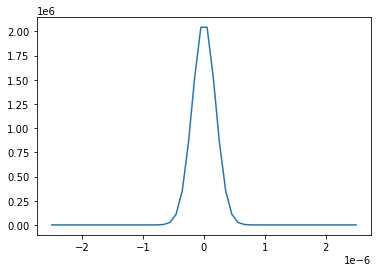

In [34]:
def zGaussian(t, z):
    sigma_x_0 = np.sqrt(mc.hbar/(mc.Rb87_M*2*np.pi*35e3))
    sigma_v = np.sqrt(mc.hbar*np.pi*35e3/mc.Rb87_M)
    sigma  = np.sqrt(sigma_v**2*(t*1e-6)**2 + sigma_x_0**2)
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(z)**2/(2*sigma**2))
plt.plot(dzPos, zGaussian(time, dzPos))
print(np.sqrt(mc.hbar/(mc.Rb87_M*2*np.pi*35e3)))

#### Trap frequency we use here is for dropping from full depth, ideally simulate in absolute units. So, this image expands relatively fast (hotter).

In [35]:
waveFunctionSlices = []
for i, zSlice in enumerate(array3D):
    zSlice = xySlice*zGaussian(time, dzPos[i])
    waveFunctionSlices.append(zSlice)
#print(waveFunctionSlices)
waveFunctionSlices = np.array(waveFunctionSlices)
print(waveFunctionSlices.shape)

(50, 2000, 2000)


In [36]:
binnedwvftn = cs.softwareBinning([20,20], waveFunctionSlices)
binnedwvftnShape = binnedwvftn.shape
size = binnedwvftnShape[1] 
print(size)
print(binnedwvftn.shape)

100
(50, 100, 100)


## Add XY blurring and DOF effects

In [24]:
reload(bf)

<module 'blurringFunctions_testingnewminblur' from 'C:\\Users\\wdwor\\Documents\\Simulation\\blurringFunctions_testingnewminblur.py'>

Text(0.5, 1.0, 'TOF = 20 us')

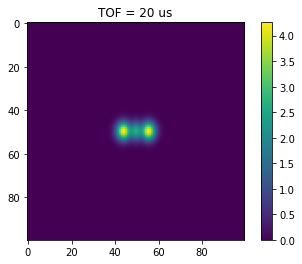

In [37]:
blurredwvftn = bf.XYZ_Blur(binnedwvftn)*1e-20
plt.imshow(blurredwvftn)
plt.colorbar()
plt.title('TOF = 20 us')

### Use fancy imshow (in matplotlibplotters give figure and axis to plot on)

## Create a list of blurred wave function at all time steps

In [200]:
reload(ib)

<module 'imageBlurring' from 'C:\\Users\\wdwor\\Documents\\Simulation\\imageBlurring.py'>

In [42]:
blurredWvftnList = ib.getBlurredImage(n1Array)

KeyboardInterrupt: 

In [ ]:
plt.imshow(blurredWvftnList[65])

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.01)

axs = axs.ravel()

everyTen = blurredWvftnList[5::10]
#plt.imshow(everyTen[5])

print(np.arange(0,len(everyTen)))

for i in np.arange(0,len(everyTen)):
    #plt.imshow(i)
    axs[i].imshow(everyTen[i])
    axs[i].set_title(str(i*20+5) + ' us expansion')

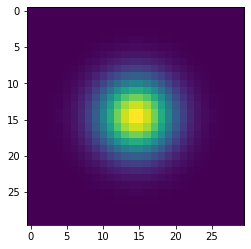

In [247]:
plt.imshow(blurredWvftnList[0][35:65, 35:65])

## Plot full simulation results of one time step

In [181]:
reload(cs)

<module 'cameraSimulation' from 'C:\\Users\\wdwor\\Documents\\Simulation\\cameraSimulation.py'>

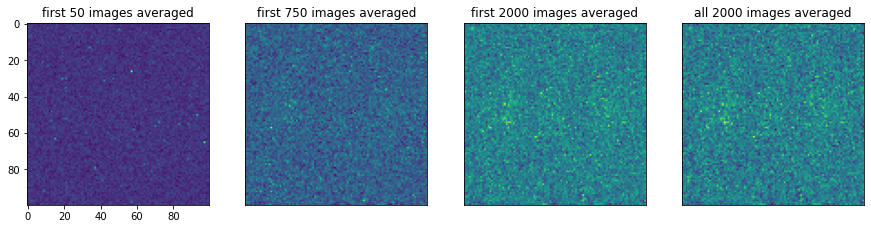

In [170]:
imageSeries = []

for imageNum in range(2500):
    imageSeries.append(cs.getSimulatedImage(blurredwvftn, size, [1,1], waveFunctionSlices))
    reportProgress(imageNum, 2500)

avgImage3 = np.mean(imageSeries [:50], 0)
avgImage25 = np.mean(imageSeries [:750], 0)
avgImage50 = np.mean(imageSeries [:2000], 0)
avgImage = np.mean(imageSeries,0)


normalizedImage3 = avgImage3/(111**2)
normalizedImage25 = avgImage25/(111**2)
normalizedImage50 = avgImage50/(111**2)
normalizedImage = avgImage/(111**2)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=[15, 15])

img0 = ax0.imshow(normalizedImage3)
ax0.set_title('first 50 images averaged')

#divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="10%", pad=0.10)
#cb0 = plt.colorbar(img0, cax=cax)

img1 = ax1.imshow(normalizedImage25)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('first 750 images averaged')

#divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="10%", pad=0.10)
#cb = plt.colorbar(img1, cax=cax)

img2 = ax2.imshow(normalizedImage50)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('first 2000 images averaged')

#divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="10%", pad=0.10)
#cb = plt.colorbar(img2, cax=cax)

img3 = ax3.imshow(normalizedImage)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('all 2000 images averaged')

#divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="10%", pad=0.10)
#cb = plt.colorbar(img3, cax=cax)

plt.show()